# Ames Housing: Project 2
#### Brandie Hatch

## Define the Problem

Increase housing access for Black individuals and families in Ames, Iowa.




## Background

The current Ames population is estimated at 58,965 (2010 Census)  https://www.cityofames.org/about-ames/interesting-facts-about-ames

This includes student enrollment at ISU.  Iowa State University of Science and Technology (ISU), it serves over 36,000 students from all over the world. 

## Data Import

In [53]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm


%matplotlib inline


from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, Ridge, Lasso, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor

pd.options.display.max_columns =999

In [54]:
ames_train = pd.read_csv('../data/train.csv')
ames_test = pd.read_csv('../data/test.csv')

In [55]:
# rename columns to snake_case 
ames_train.columns = ames_train.columns.str.lower().str.replace(' ', '_')
ames_test.columns = ames_test.columns.str.lower().str.replace(' ', '_')

# change column name for "year_remod/add" to remove the "/""
ames_train.columns = ['year_remod_add' if x=='year_remod/add' else x for x in ames_train.columns]
ames_test.columns = ['year_remod_add' if x=='year_remod/add' else x for x in ames_test.columns]

In [56]:
ames_test.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod_add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NaN,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NaN,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1935.0,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NaN,NaN,NaN,0,7,2009,WD


## Data Exploration

In [57]:
ames_train.shape, ames_test.shape

((2051, 81), (878, 80))

In [58]:
set(ames_train.columns) - set(ames_test.columns)

{'saleprice'}

In [59]:
ames_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   int64  
 2   ms_subclass      2051 non-null   int64  
 3   ms_zoning        2051 non-null   object 
 4   lot_frontage     1721 non-null   float64
 5   lot_area         2051 non-null   int64  
 6   street           2051 non-null   object 
 7   alley            140 non-null    object 
 8   lot_shape        2051 non-null   object 
 9   land_contour     2051 non-null   object 
 10  utilities        2051 non-null   object 
 11  lot_config       2051 non-null   object 
 12  land_slope       2051 non-null   object 
 13  neighborhood     2051 non-null   object 
 14  condition_1      2051 non-null   object 
 15  condition_2      2051 non-null   object 
 16  bldg_type        2051 non-null   object 
 17  house_style   

In [60]:
ames_train.isnull().sum().sort_values(ascending=False).loc[lambda x: x > 0]
# None of the columns planned to be used hold null or na data

pool_qc           2042
misc_feature      1986
alley             1911
fence             1651
fireplace_qu      1000
lot_frontage       330
garage_finish      114
garage_qual        114
garage_yr_blt      114
garage_cond        114
garage_type        113
bsmt_exposure       58
bsmtfin_type_2      56
bsmtfin_type_1      55
bsmt_cond           55
bsmt_qual           55
mas_vnr_area        22
mas_vnr_type        22
bsmt_half_bath       2
bsmt_full_bath       2
garage_area          1
total_bsmt_sf        1
bsmt_unf_sf          1
bsmtfin_sf_2         1
bsmtfin_sf_1         1
garage_cars          1
dtype: int64

In [61]:
ames_test.isnull().sum().sort_values(ascending=False).loc[lambda x: x >0]
# None of the columns planned to be used hold null or na data

pool_qc           874
misc_feature      837
alley             820
fence             706
fireplace_qu      422
lot_frontage      160
garage_yr_blt      45
garage_finish      45
garage_qual        45
garage_cond        45
garage_type        44
bsmtfin_type_1     25
bsmt_qual          25
bsmt_cond          25
bsmt_exposure      25
bsmtfin_type_2     25
electrical          1
mas_vnr_type        1
mas_vnr_area        1
dtype: int64

C:\Users\hatch\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


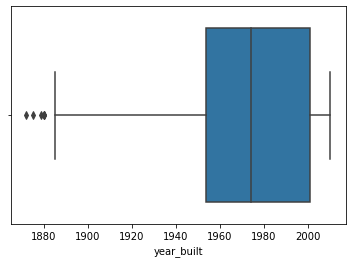

In [62]:
sns.boxplot(ames_train.year_built);

C:\Users\hatch\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


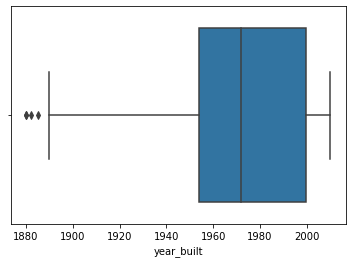

In [63]:
sns.boxplot(ames_test.year_built);

C:\Users\hatch\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


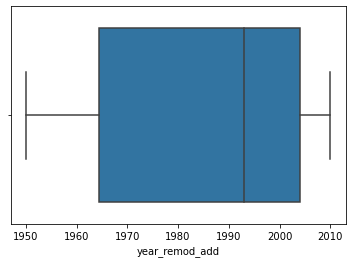

In [64]:
sns.boxplot(ames_train.year_remod_add);

C:\Users\hatch\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


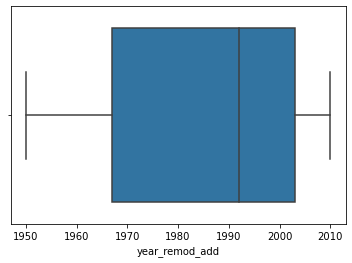

In [65]:
sns.boxplot(ames_test.year_remod_add);

#### The two boxplots for ms_subclass identify the type of dwelling involved in the sale. It is logical for there to be a couple of outliers at the higher end of the data (especially since none go over the max 190) because the dictionary shows those as different types of Planned Unit Developments (PUD). [A PUD is a community of single family homes. The homes could be condos or townhomes and there is often a homeowners association (HOA)](https://www.forbes.com/advisor/mortgages/what-is-a-planned-unit-development/).

C:\Users\hatch\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


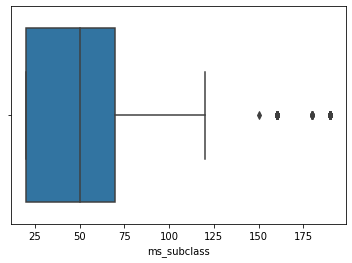

In [66]:
sns.boxplot(ames_train.ms_subclass);

C:\Users\hatch\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


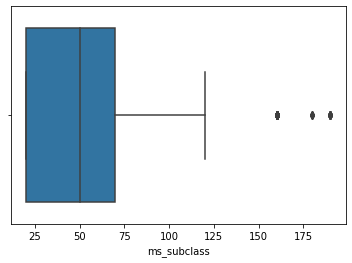

In [67]:
sns.boxplot(ames_test.ms_subclass);

In [68]:
ames_train['ms_subclass'].describe()

count    2051.000000
mean       57.008776
std        42.824223
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: ms_subclass, dtype: float64

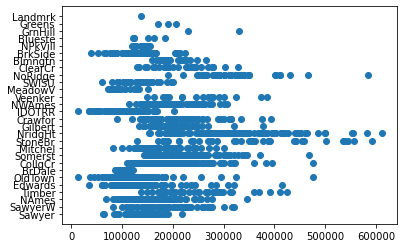

In [69]:
plt.scatter(x='saleprice', y='neighborhood', data=ames_train)

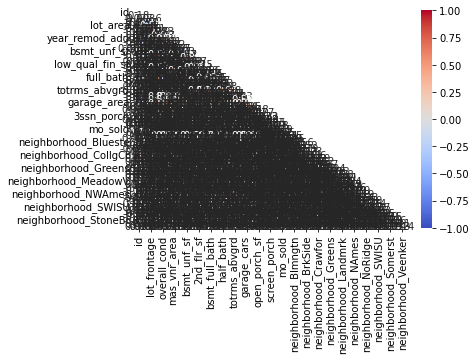

In [70]:
ames_train_dum = pd.get_dummies(ames_train, columns=['neighborhood'])
mask = np.triu(np.ones_like(ames_train_dum.corr(), dtype=bool))
sns.heatmap(ames_train_dum.corr(), vmin=-1, vmax=1, cmap='coolwarm', mask=mask, annot=True);

In [71]:
neighborhoods = ames_train.sort_values(by='saleprice', ascending=False)

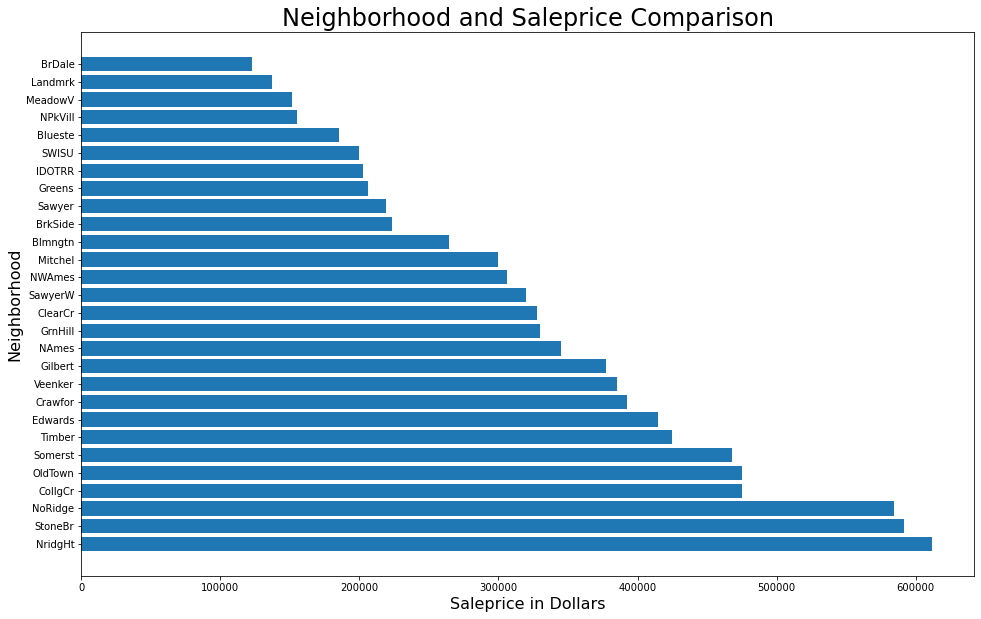

In [72]:
plt.figure(figsize=(16, 10))
plt.barh(
    y='neighborhood',
    width='saleprice',
    data=neighborhoods
)
plt.title("Neighborhood and Saleprice Comparison", fontdict={"fontsize": 24})
plt.xlabel("Saleprice in Dollars", fontsize = 16)
plt.ylabel("Neighborhood", fontsize = 16);

In [73]:
# Duplicate and rename neighborhood column to create the beginning of the neighborhood code 'n_code' column for future feature use
ames_train['n_code'] = ames_train['neighborhood']
ames_test['n_code'] = ames_test['neighborhood']

In [74]:
neighborhood_6sort_dict = {
    'Blmngtn': 'N',
    'Blueste': 'SWISU',
    'BrDale': 'N',
    'BrkSide': 'E',
    'ClearCr': 'NW',
    'CollgCr': 'S',
    'Crawfor': 'SWISU',
    'Edwards': 'S',
    'Gilbert': 'N',
    'Greens': 'ISU',
    'GrnHill': 'S',
    'IDOTRR': 'E',
    'Landmrk': 'ISU',
    'MeadowV': 'S',
    'Mitchel': 'S',
    'NAmes': 'N',
    'NoRidge': 'N',
    'NPkVill': 'N',
    'NridgHt': 'N',
    'NWAmes': 'N',
    'OldTown': 'E',
    'Sawyer': 'NW',
    'SawyerW': 'NW',
    'Somerst': 'N',
    'StoneBr': 'N',
    'SWISU': 'SWISU',
    'Timber': 'S',
    'Veenker': 'NW'
}

In [75]:
ames_train = ames_train.replace({'n_code': neighborhood_6sort_dict})

In [76]:
ames_test = ames_test.replace({'n_code': neighborhood_6sort_dict})

### Prepare training data: split into training and validation sets

In [77]:
features = ['id', 'ms_subclass', 'ms_zoning', 'neighborhood', 'n_code', 'condition_1', 'condition_2', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'sale_type']
X = ames_train[features]
y = ames_train['saleprice']

# drop 'pid' column data from test to match train
ames_test = ames_test[['id', 'ms_subclass', 'ms_zoning', 'neighborhood', 'n_code', 'condition_1',	'condition_2', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'sale_type']]

In [78]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=37
)

In [79]:
# check shapes
print(f"Shape of original data frame: {ames_train.shape}")
print(" ")
print(f"Shape of X train: {X_train.shape}")
print(f"Shape of y train: {y_train.shape}")
print(" ")
print(f"Shape of X validation: {X_val.shape}")
print(f"Shape of y validation: {y_val.shape}")
print(" ")
print(f"Shape of test: {ames_test.shape}")

Shape of original data frame: (2051, 82)
 
Shape of X train: (1640, 12)
Shape of y train: (1640,)
 
Shape of X validation: (411, 12)
Shape of y validation: (411,)
 
Shape of test: (878, 12)


### Data Dictionary and Save Cleaned CSV 

https://www.tablesgenerator.com/markdown_tables#

|Feature|Type|Dataset|Description|
|---|---|---|---|
|**school_code**|*integer*|FRPM & ACT/SAT|The school code is a state number to identify schools. It is how all of the data frames connect.|
|**charter_y_n**|*object*|FRPM|Yes or No; this school is a Charter School|
|**school_name**|*object*|FRPM & ACT/SAT|School Name|

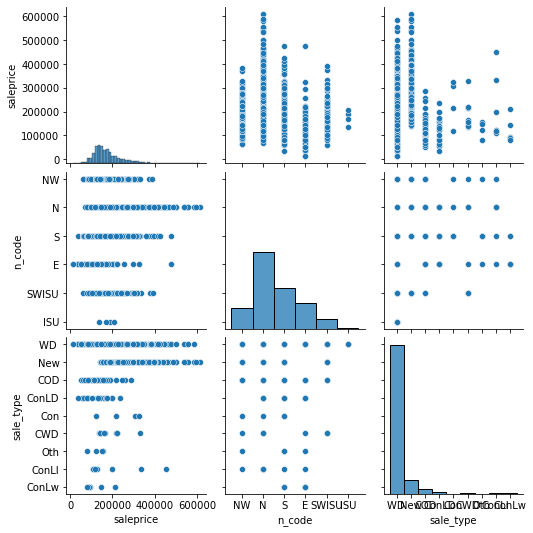

In [80]:
sns.pairplot(ames_train, vars=['saleprice', 'n_code', 'sale_type'])

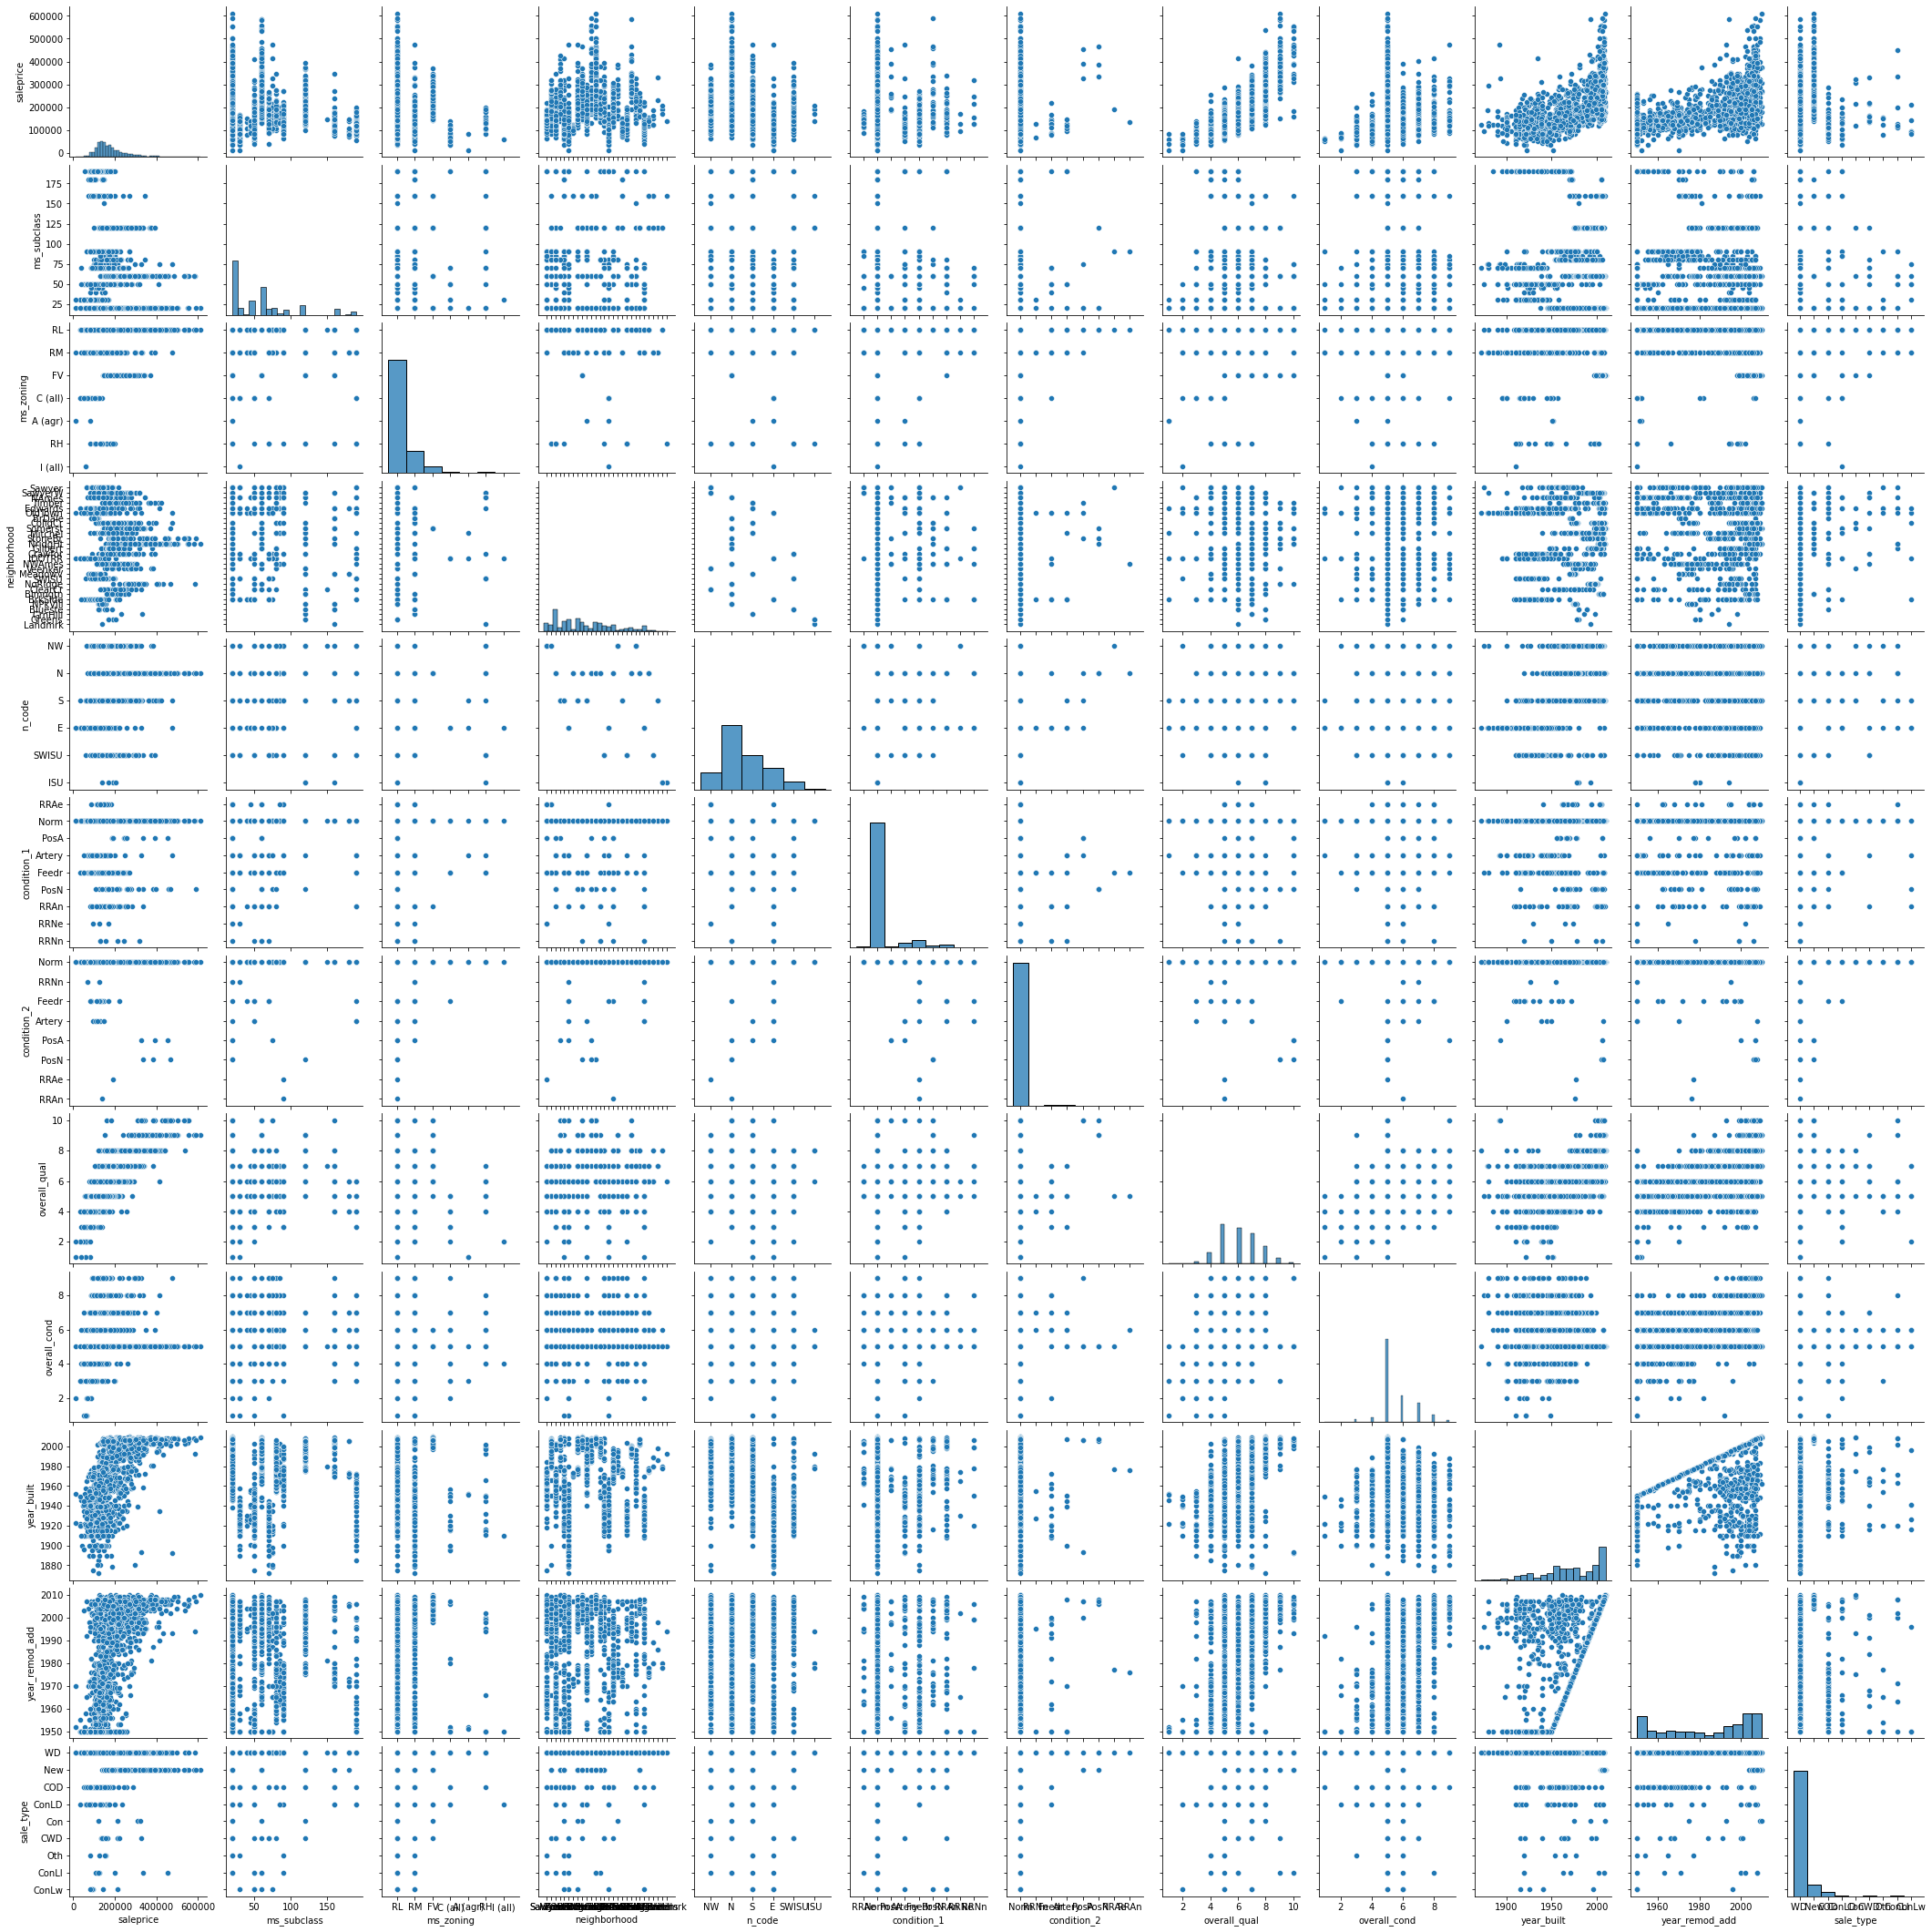

In [81]:
sns.pairplot(ames_train, vars=['saleprice', 'ms_subclass', 'ms_zoning', 'neighborhood', 'n_code', 'condition_1', 'condition_2', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'sale_type'])

## Feature Engineering

what to remove? what to keep?
Choosing to start looking at columns for MSSubclass, MSzoning, Neighborhood, Condition 1, Condition 2, year_built	year,_remod/add and Sale Type, OverallQual: Material, OverallCond: Overall rating


In [82]:
X_train['n_code'].value_counts(ascending=False)

N        721
S        369
E        257
NW       197
SWISU     94
ISU        2
Name: n_code, dtype: int64

In [83]:
X_train.head()

,id,ms_subclass,ms_zoning,neighborhood,n_code,condition_1,condition_2,overall_qual,overall_cond,year_built,year_remod_add,sale_type
653,1417,50,RL,Edwards,S,Artery,Norm,6,5,1924,1950,WD
381,1005,60,RL,Gilbert,N,Norm,Norm,6,5,1998,1998,WD
176,2432,60,RL,Gilbert,N,Norm,Norm,6,5,2002,2003,WD
1283,2778,60,RL,CollgCr,S,Norm,Norm,7,5,1999,2000,WD
188,2569,60,RL,NAmes,N,Norm,Norm,7,6,1966,1966,WD


In [84]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1640 entries, 653 to 1935
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1640 non-null   int64 
 1   ms_subclass     1640 non-null   int64 
 2   ms_zoning       1640 non-null   object
 3   neighborhood    1640 non-null   object
 4   n_code          1640 non-null   object
 5   condition_1     1640 non-null   object
 6   condition_2     1640 non-null   object
 7   overall_qual    1640 non-null   int64 
 8   overall_cond    1640 non-null   int64 
 9   year_built      1640 non-null   int64 
 10  year_remod_add  1640 non-null   int64 
 11  sale_type       1640 non-null   object
dtypes: int64(6), object(6)
memory usage: 166.6+ KB


In [85]:
X_train['neighborhood'].value_counts()

NAmes      253
CollgCr    141
OldTown    130
Edwards    108
NridgHt    101
Somerst     99
Gilbert     88
Sawyer      87
SawyerW     76
NWAmes      70
BrkSide     68
Mitchel     64
Crawfor     62
IDOTRR      59
NoRidge     36
Timber      35
StoneBr     28
SWISU       28
ClearCr     22
Blmngtn     20
MeadowV     20
BrDale      15
Veenker     12
NPkVill     11
Blueste      4
Greens       1
GrnHill      1
Landmrk      1
Name: neighborhood, dtype: int64

In [86]:
X_train['ms_zoning'].value_counts()

RL         1271
RM          260
FV           80
C (all)      17
RH           11
A (agr)       1
Name: ms_zoning, dtype: int64

In [87]:
X_train['sale_type'].value_counts()

WD       1424
New       122
COD        56
ConLD      12
CWD         9
ConLI       5
ConLw       4
Oth         4
Con         4
Name: sale_type, dtype: int64

In [88]:
tr_id = X_train['id']
val_id = X_val['id']

X_train.drop(columns = ['id'], inplace = True)
X_val.drop(columns = ['id'], inplace = True)

In [89]:
X_train.drop(columns = ['neighborhood'], inplace = True)
X_val.drop(columns = ['neighborhood'], inplace = True)

In [90]:
# Created using the Extra, Extra Saturday class content

number_data = [col for col in X_train._get_numeric_data().columns if col not in ['id', 'saleprice']]

categorical_data = [col for col in X_train.columns if col not in number_data and col not in ['id', 'saleprice']]

ctx = ColumnTransformer(
    [('ss', StandardScaler(), number_data),
    ('ohe', OneHotEncoder(handle_unknown='ignore', dtype=np.int64, ), categorical_data)
    ]
)

# Linear Regression Pipeline
lr_pipe = Pipeline([
    ('ctx', ctx),
    ('lr', TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp))
])

# Ridge Pipeline
rg_pipe = Pipeline([
    ('ctx', ctx),
    ('rg', TransformedTargetRegressor(Ridge(), func=np.log, inverse_func=np.exp))
])

# Lasso Pipeline
lasso_pipe = Pipeline([
    ('ctx', ctx),
    ('lasso', TransformedTargetRegressor(Lasso(), func=np.log, inverse_func=np.exp))
])

# ElasticNet Pipeline
enet_pipe = Pipeline([
    ('ctx', ctx),
    ('enet', TransformedTargetRegressor(ElasticNet(), func=np.log, inverse_func=np.exp))
])

# KNeighborsRegressor Pipeline
knn_pipe = Pipeline([
    ('ctx', ctx),
    ('knn', TransformedTargetRegressor(KNeighborsRegressor(), func=np.log, inverse_func=np.exp))
])



In [91]:
rg_params = {
    'ctx__remainder' : ['passthrough'], # keep untransformed columns and do nothing
    'ctx__ss__with_mean' : [True, False],
    'rg__regressor__alpha' : [.01, .1, 1000]
}

lasso_params = {
    'ctx__remainder' : ['passthrough'], 
    'ctx__regressor__alpha' : np.linspace(.001, 10, 100),
    'lr__regressor__max_iter' : [10000]
}


gs = GridSearchCV(
    rg_pipe,
    rg_params,
    cv=5
)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ctx',
                                        ColumnTransformer(transformers=[('ss',
                                                                         StandardScaler(),
                                                                         ['ms_subclass',
                                                                          'overall_qual',
                                                                          'overall_cond',
                                                                          'year_built',
                                                                          'year_remod_add']),
                                                                        ('ohe',
                                                                         OneHotEncoder(dtype=<class 'numpy.int64'>,
                                                                                       handle_unknown='ignore'),
    

In [92]:
gs.best_score_

0.729622711198686

In [93]:
gs.score(X_val, y_val)

0.7142241093245367

In [94]:
gs.best_params_

{'ctx__remainder': 'passthrough',
 'ctx__ss__with_mean': False,
 'rg__regressor__alpha': 0.1}

In [95]:
gs.best_estimator_

Pipeline(steps=[('ctx',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss',
                                                  StandardScaler(with_mean=False),
                                                  ['ms_subclass',
                                                   'overall_qual',
                                                   'overall_cond', 'year_built',
                                                   'year_remod_add']),
                                                 ('ohe',
                                                  OneHotEncoder(dtype=<class 'numpy.int64'>,
                                                                handle_unknown='ignore'),
                                                  ['ms_zoning', 'n_code',
                                                   'condition_1', 'condition_2',
                                                   'sale_type'])])),
                ('rg',
     

In [96]:
test_id = ames_test['id']

In [97]:
preds = gs.predict(ames_test)
preds = pd.DataFrame(preds, columns=['saleprice'])

In [98]:
preds.insert(loc = 0, column = 'id', value = test_id)

In [99]:
preds.head()

,id,saleprice
0,2658,121245.570944
1,2718,133465.544375
2,2414,231062.576499
3,1989,118003.417813
4,625,160765.507860


In [100]:
preds.shape

(878, 2)

In [101]:
preds.to_csv('../submissions/pipe_gs_3.csv', index = False)

In [102]:
# https://www.analyticsvidhya.com/blog/2021/05/how-to-perform-one-hot-encoding-for-multi-categorical-variables/
# [['ms_zoning', 'neighborhood', 'condition_1', 'condition_2', 'sale_type']]

## Preprocessing

## Model with Data

In [103]:
pfs = Pipeline([
    ('pf', PolynomialFeatures()),
    ('sc', StandardScaler()),
])
ctx = ColumnTransformer([
    ('pfs', pfs, ['A', 'C']),
    ('ohe', OneHotEncoder(), ['B'])
])
ctx.fit_transform(train)

pipe = Pipeline([
    ('ctx', ctx),
    ('lr', LinearRegression())
])

pipe.fit(train, y)

NameError: name 'train' is not defined

## Evaluate Models

In [ ]:
# Kaggle competition submission score

In [ ]:
# Use Confusion Matrix
confu

In [ ]:
fig

## Visualize the Data and Models

In [ ]:
# 1. Correlation Heatmap 
plt.figure(figsize=(12,12))
mask = np.triu(np.ones_like(frpm_act_sat.corr(), dtype=bool))
sns.heatmap(frpm_act_sat.corr(), vmin=-1, vmax=1, cmap='ocean', mask=mask, annot=True)
plt.title('FRPM Compared to SAT & ACT Scores', fontsize=22);

NameError: name 'frpm_act_sat' is not defined

<Figure size 864x864 with 0 Axes>

## Answer Problem, Conclusions, and Recommendations

## Sources:

* Ames, Iowa Assessor's Office http://jse.amstat.org/v19n3/decock/DataDocumentation.txt